In [1]:
# Dependencies
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sn

# linear modelling
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data_all = "Output/2019_2020_mixed_beverage"
df_all = pd.read_csv(data_all, encoding="utf-8")
file_path = "Output/census_data.csv"
censusdf = pd.read_csv(file_path, encoding="utf-8")

In [3]:
censusdf2 = censusdf.loc[censusdf['Per Capita Income']<200000]


In [4]:
censusdf2.rename(columns={'Zipcode' : 'location_zip'},inplace=True)


C:\Users\19729\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
#efficient way to extract year from string format date
df_all['year'] = pd.DatetimeIndex(df_all['obligation_end_date_yyyymmdd']).year
df_all['month'] = pd.DatetimeIndex(df_all['obligation_end_date_yyyymmdd']).month
city_mask = (df_all.location_city == "HOUSTON")|(df_all.location_city == "DALLAS")|(df_all.location_city == "FORT WORTH")|(df_all.location_city == "SAN ANTONIO")|(df_all.location_city == "AUSTIN")
dfcities = df_all[city_mask]
dfcities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44006 entries, 3 to 119998
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   taxpayer_number                      44006 non-null  int64  
 1   taxpayer_name                        44006 non-null  object 
 2   taxpayer_address                     44006 non-null  object 
 3   taxpayer_city                        44006 non-null  object 
 4   taxpayer_state                       43992 non-null  object 
 5   taxpayer_zip                         43992 non-null  float64
 6   taxpayer_county                      44006 non-null  int64  
 7   location_number                      44006 non-null  int64  
 8   location_name                        44006 non-null  object 
 9   location_address                     44006 non-null  object 
 10  location_city                        44006 non-null  object 
 11  location_state             

In [6]:
#2019 zips vs census data
mask_2019 = dfcities.year == 2019
df_2019 = dfcities[mask_2019]
zip_sales_2019 = pd.DataFrame(df_2019.groupby('location_zip')['total_receipts'].sum()).reset_index()
regres_2019 = pd.merge(zip_sales_2019,censusdf2,on="location_zip",how="left")
clean_regress_2019 = regres_2019.dropna(how='any')
clean_regress_2019.corr()['total_receipts'].reset_index()
clean_regress_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 270 entries, 0 to 273
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   location_zip       270 non-null    int64  
 1   total_receipts     270 non-null    int64  
 2   Population         270 non-null    float64
 3   Median Age         270 non-null    float64
 4   Household Income   270 non-null    float64
 5   Per Capita Income  270 non-null    float64
 6   Poverty Count      270 non-null    float64
 7   Poverty Rate       270 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 19.0 KB


In [7]:
#2020 zips vs census data
mask_2020 = dfcities.year == 2020
df_2020 = dfcities[mask_2020]
zip_sales_2020 = pd.DataFrame(df_2020.groupby('location_zip')['total_receipts'].sum()).reset_index()
regres_2020 = pd.merge(zip_sales_2020,censusdf2,on="location_zip",how="left")
clean_regress_2020 = regres_2020.dropna(how='any')
clean_regress_2020.corr()['total_receipts'].reset_index()
clean_regress_2020.corr()

,location_zip,total_receipts,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate
location_zip,1.000000,-0.045492,-0.040948,0.054444,-0.019764,0.031247,-0.129663,-0.157454
total_receipts,-0.045492,1.000000,-0.085313,0.122639,0.045114,0.485268,-0.169553,-0.153247
Population,-0.040948,-0.085313,1.000000,-0.263761,0.137042,-0.221202,0.705509,0.022380
Median Age,0.054444,0.122639,-0.263761,1.000000,0.242547,0.531479,-0.468118,-0.334846
Household Income,-0.019764,0.045114,0.137042,0.242547,1.000000,0.123332,0.102696,0.144566
Per Capita Income,0.031247,0.485268,-0.221202,0.531479,0.123332,1.000000,-0.536541,-0.663714
Poverty Count,-0.129663,-0.169553,0.705509,-0.468118,0.102696,-0.536541,1.000000,0.588147
Poverty Rate,-0.157454,-0.153247,0.022380,-0.334846,0.144566,-0.663714,0.588147,1.000000


The r-squared is: 0.17128906610663705


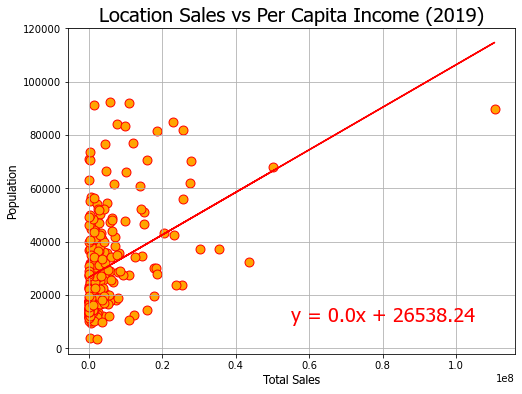

In [8]:
# 2019 zip total sales vs Per Capita Income
plt.figure(figsize=(8,6))
hfont = {'fontname':'Tahoma'}
x_values = clean_regress_2019['total_receipts']
y_values = clean_regress_2019['Per Capita Income']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,color='orange',edgecolor="red",s=80)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(55000000,10000),font='Tahoma',fontsize=20,color="red")
plt.xlabel('Total Sales',**hfont,fontsize=12)
plt.ylabel('Population',**hfont,fontsize=12)
plt.title("Location Sales vs Per Capita Income (2019)",**hfont,fontsize=20)
print(f"The r-squared is: {rvalue**2}")
plt.grid()
plt.savefig("../SMU_Project1_Group1/regressiong_sales_vs_income_2019")
plt.show()

The r-squared is: 0.23548527744499823


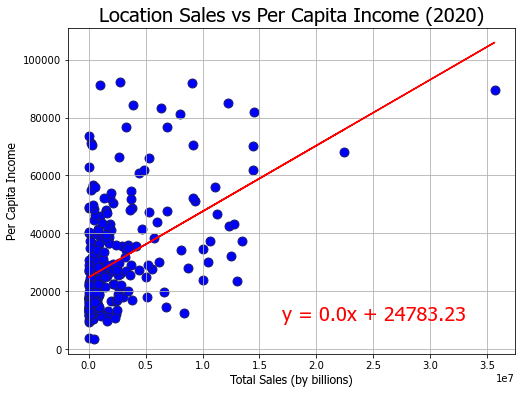

In [9]:
# 2020 zip total sales vs Per Capita Income
plt.figure(figsize=(8,6))
hfont = {'fontname':'Tahoma'}
x_values = clean_regress_2020['total_receipts']
y_values = clean_regress_2020['Per Capita Income']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values,color='blue',edgecolor="midnightblue",s=80)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(17000000,10000),font='Tahoma',fontsize=20,color="red")
plt.xlabel('Total Sales (by billions)',**hfont,fontsize=12)
plt.ylabel('Per Capita Income',**hfont,fontsize=12)
plt.title("Location Sales vs Per Capita Income (2020)",**hfont,fontsize=20)
print(f"The r-squared is: {rvalue**2}")
plt.grid()
plt.savefig("../SMU_Project1_Group1/regressiong_sales_vs_income_2020")
plt.show()

In [24]:
#2020 Total Sales vs Income STATSMODELS
feature = clean_regress_2020['Per Capita Income']
target = clean_regress_2020['total_receipts']

X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_receipts   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     84.09
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           1.19e-17
Time:                        11:54:29   Log-Likelihood:                -4529.0
No. Observations:                 275   AIC:                             9062.
Df Residuals:                     273   BIC:                             9069.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -7.912e+05   3.98e+05     -1.989      0.048   -1.57e+06   -7958.456
Per Capita Income   103.4494     11.281      9.170      0.000      81.240     125.659
==============================================================================
Omnibus:                      206.849   Durbin-Watson:                   1.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3273.623
Skew:                           2.875   Prob(JB):                         0.00
Kurtosis:                      18.894   Cond. No.                     6.74e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.74e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The r-squared is: 0.026607114316927073


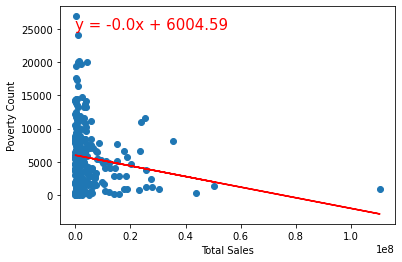

In [10]:
# 2019 zip total sales vs Poverty Count
x_values = clean_regress_2019['total_receipts']
y_values = clean_regress_2019['Poverty Count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.6,25000),fontsize=15,color="red")
plt.xlabel('Total Sales')
plt.ylabel('Poverty Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.028748216647811027


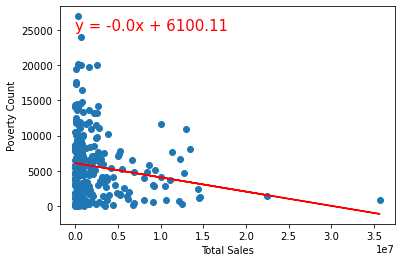

In [11]:
# 2020 zip total sales vs Poverty Count
x_values = clean_regress_2020['total_receipts']
y_values = clean_regress_2020['Poverty Count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(.6,25000),fontsize=15,color="red")
plt.xlabel('Total Sales')
plt.ylabel('Poverty Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.018496510607882596


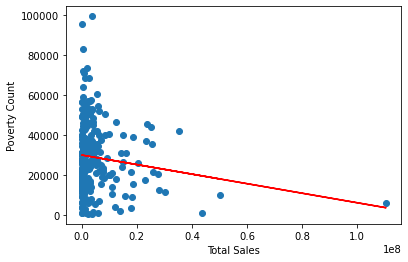

In [12]:
# 2019 zip total sales vs Population
x_values = clean_regress_2019['total_receipts']
y_values = clean_regress_2019['Population']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(.6,25000),fontsize=15,color="red")
plt.xlabel('Total Sales')
plt.ylabel('Poverty Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.007278319826071254


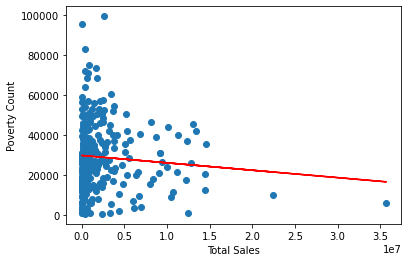

In [13]:
# 2020 zip total sales vs Population
x_values = clean_regress_2020['total_receipts']
y_values = clean_regress_2020['Population']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
# plt.annotate(line_eq,(.6,25000),fontsize=15,color="red")
plt.xlabel('Total Sales')
plt.ylabel('Poverty Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [14]:
cityzip_2019_stores = df_2019.loc[:,["location_zip","location_address"]].drop_duplicates().reset_index(drop=True)
zip_unique_stores = cityzip_2019_stores.location_zip.value_counts().reset_index().rename(columns={'index':'location_zip','location_zip':'store_count'})
zip_unique_stores

,location_zip,store_count
0,78701,206
1,77002,121
2,78205,117
3,75201,95
4,78704,89
...,...,...
269,77204,1
270,75390,1
271,78747,1
272,78739,1


In [16]:
#2019 zip code and census, includes city
cityzip_2019 = pd.DataFrame(df_2019.groupby(['location_city','location_zip'])['total_receipts'].sum()).reset_index()
cityzip_2019 = pd.merge(cityzip_2019,censusdf2,on="location_zip",how="left")
cityzip_2019 = cityzip_2019.dropna(how='any')
cityzip_2019 = pd.merge(cityzip_2019,zip_unique_stores,on="location_zip",how='left')
cityzip_2019['store_avg']=cityzip_2019.total_receipts/cityzip_2019.store_count
cityzip_2019.corr()

,location_zip,total_receipts,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,store_count,store_avg
location_zip,1.000000,-0.005286,-0.045081,0.045959,-0.020767,0.037352,-0.132216,-0.167753,-0.038823,0.069383
total_receipts,-0.005286,1.000000,-0.136002,0.109069,0.029462,0.413871,-0.163117,-0.091942,0.913979,0.394871
Population,-0.045081,-0.136002,1.000000,-0.256392,0.139493,-0.228387,0.710219,0.035471,-0.017495,-0.211534
Median Age,0.045959,0.109069,-0.256392,1.000000,0.246488,0.528371,-0.462541,-0.324609,0.120210,0.026479
Household Income,-0.020767,0.029462,0.139493,0.246488,1.000000,0.124593,0.103000,0.144971,0.059748,-0.129238
Per Capita Income,0.037352,0.413871,-0.228387,0.528371,0.124593,1.000000,-0.540146,-0.662944,0.403738,0.302759
Poverty Count,-0.132216,-0.163117,0.710219,-0.462541,0.103000,-0.540146,1.000000,0.594708,-0.094533,-0.273134
Poverty Rate,-0.167753,-0.091942,0.035471,-0.324609,0.144971,-0.662944,0.594708,1.000000,-0.088018,-0.226554
store_count,-0.038823,0.913979,-0.017495,0.120210,0.059748,0.403738,-0.094533,-0.088018,1.000000,0.280105
store_avg,0.069383,0.394871,-0.211534,0.026479,-0.129238,0.302759,-0.273134,-0.226554,0.280105,1.000000


In [18]:
#2020 zip code and census, includes city
cityzip_2020 = pd.DataFrame(df_2020.groupby(['location_city','location_zip'])['total_receipts'].sum()).reset_index()
cityzip_2020 = pd.merge(cityzip_2020,censusdf2,on="location_zip",how="left")
cityzip_2020 = pd.merge(cityzip_2020,zip_unique_stores,on="location_zip",how='left')
cityzip_2020['store_avg']=cityzip_2020.total_receipts/cityzip_2019.store_count
cityzip_2020 = cityzip_2020.dropna(how='any')
cityzip_2020.corr()

,location_zip,total_receipts,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,store_count,store_avg
location_zip,1.000000,-0.042303,-0.020714,0.036437,-0.024014,0.016726,-0.103418,-0.140676,-0.030454,-0.089030
total_receipts,-0.042303,1.000000,-0.090618,0.129923,0.046491,0.482843,-0.175857,-0.161115,0.923076,0.414099
Population,-0.020714,-0.090618,1.000000,-0.254946,0.144391,-0.217997,0.707694,0.014046,-0.029461,0.006748
Median Age,0.036437,0.129923,-0.254946,1.000000,0.251079,0.525905,-0.465013,-0.311970,0.119376,0.102314
Household Income,-0.024014,0.046491,0.144391,0.251079,1.000000,0.125125,0.107810,0.151783,0.061076,0.030414
Per Capita Income,0.016726,0.482843,-0.217997,0.525905,0.125125,1.000000,-0.535159,-0.665348,0.408184,0.281955
Poverty Count,-0.103418,-0.175857,0.707694,-0.465013,0.107810,-0.535159,1.000000,0.582278,-0.106645,-0.102275
Poverty Rate,-0.140676,-0.161115,0.014046,-0.311970,0.151783,-0.665348,0.582278,1.000000,-0.101660,-0.138119
store_count,-0.030454,0.923076,-0.029461,0.119376,0.061076,0.408184,-0.106645,-0.101660,1.000000,0.334875
store_avg,-0.089030,0.414099,0.006748,0.102314,0.030414,0.281955,-0.102275,-0.138119,0.334875,1.000000


<AxesSubplot:>

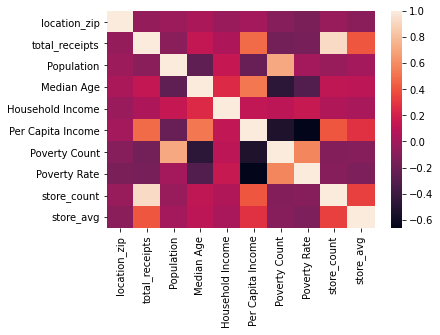

In [19]:
sn.heatmap(cityzip_2020.corr())

The r-squared is: 0.8353579085310878


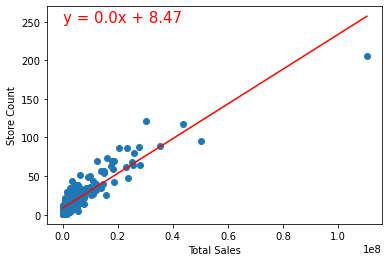

In [20]:
# 2019 zip total sales vs store count
x_values = cityzip_2019['total_receipts']
y_values = cityzip_2019['store_count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,250),fontsize=15,color="red")
plt.xlabel('Total Sales')
plt.ylabel('Store Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

The r-squared is: 0.852068608652947


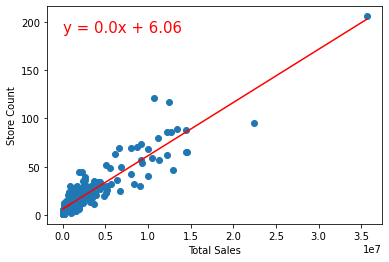

In [21]:
# 2020 zip total sales vs store count
x_values = cityzip_2020['total_receipts']
y_values = cityzip_2020['store_count']
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,190),fontsize=15,color="red")
plt.xlabel('Total Sales')
plt.ylabel('Store Count')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [32]:
#2020 Location Count vs Income/Population STATSMODELS
feature = cityzip_2020[['Per Capita Income','Population']]
target = cityzip_2020['store_count']

X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            store_count   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     26.48
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           3.46e-11
Time:                        12:17:51   Log-Likelihood:                -1174.1
No. Observations:                 261   AIC:                             2354.
Df Residuals:                     258   BIC:                             2365.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2390      3.877      0.062      0.951      -7.396       7.874
Per Capita Income     0.0005   7.51e-05      7.259      0.000       0.000       0.001
Population         8.868e-05   8.25e-05      1.075      0.283   -7.37e-05       0.000
==============================================================================
Omnibus:                      182.833   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2108.752
Skew:                           2.700   Prob(JB):                         0.00
Kurtosis:                      15.836   Cond. No.                     1.28e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
#2020 Location Count vs Income STATSMODELS
feature = cityzip_2020[['Per Capita Income']]
target = cityzip_2020['store_count']

X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            store_count   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     51.78
Date:                Tue, 03 Aug 2021   Prob (F-statistic):           6.69e-12
Time:                        12:17:28   Log-Likelihood:                -1174.7
No. Observations:                 261   AIC:                             2353.
Df Residuals:                     259   BIC:                             2360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3621      2.570      1.308      0.192      -1.699       8.423
Per Capita Income     0.0005   7.33e-05      7.196      0.000       0.000       0.001
==============================================================================
Omnibus:                      177.119   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1921.207
Skew:                           2.608   Prob(JB):                         0.00
Kurtosis:                      15.225   Cond. No.                     6.66e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
#2020 Location Count vs Pop STATSMODELS
feature = cityzip_2020[['Population']]
target = cityzip_2020['store_count']

X = sm.add_constant(feature)
Y = target

model = sm.OLS(Y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            store_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2250
Date:                Tue, 03 Aug 2021   Prob (F-statistic):              0.636
Time:                        12:17:19   Log-Likelihood:                -1198.3
No. Observations:                 261   AIC:                             2401.
Df Residuals:                     259   BIC:                             2408.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3055      2.978      6.818      0.000      14.441      26.170
Population -4.181e-05   8.81e-05     -0.474      0.636      -0.000       0.000
==============================================================================
Omnibus:                      210.650   Durbin-Watson:                   1.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3156.496
Skew:                           3.189   Prob(JB):                         0.00
Kurtosis:                      18.798   Cond. No.                     6.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""